## Visualizing Filters and Feature Maps in Convolutional Neural Networks

In [ ]:
# Import all the libraries and modules
import torch
import torch.nn as nn
from torchvision import models
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv

In [ ]:
# load the ResNet18 model
model = models.resnet18(pretrained=True)
model

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:

model_weights = [] # Save the conv layer weights in this list
conv_layers = [] # Save the conv layers in this list

# get all the model children as list
model_children = list(model.children())
print(model_children[4])

Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)


We need to save all the convolutional layers and the respective weights.

Specifically, we are checking for convolutional layers at three levels of nesting.

In [ ]:
# counter to keep count of the conv layers
counter = 0 

# append all the conv layers and their respective weights to the list
for i in range(len(model_children)):
    # checks if any of the direct children of the model is a convolutional layer
    if type(model_children[i]) == nn.Conv2d:
        counter += 1
        model_weights.append(model_children[i].weight)
        conv_layers.append(model_children[i])
    
    # check whether any of the BasicBlock or Bottleneck layer 
    # inside the Sequential blocks contain any convolutional layers.
    elif type(model_children[i]) == nn.Sequential:
        for j in range(len(model_children[i])):
            for child in model_children[i][j].children():
                if type(child) == nn.Conv2d:
                    counter += 1
                    model_weights.append(child.weight)
                    conv_layers.append(child)
                    
print(f"Total convolutional layers: {counter}")

Total convolutional layers: 17


In [ ]:
# take a look at the conv layers and the respective weights
for weight, conv in zip(model_weights, conv_layers):
    # print(f"WEIGHT: {weight} \nSHAPE: {weight.shape}")
    print(f"CONV: {conv} ====> SHAPE: {weight.shape}")

CONV: Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False) ====> SHAPE: torch.Size([64, 3, 7, 7])
CONV: Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) ====> SHAPE: torch.Size([64, 64, 3, 3])
CONV: Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) ====> SHAPE: torch.Size([64, 64, 3, 3])
CONV: Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) ====> SHAPE: torch.Size([64, 64, 3, 3])
CONV: Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) ====> SHAPE: torch.Size([64, 64, 3, 3])
CONV: Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False) ====> SHAPE: torch.Size([128, 64, 3, 3])
CONV: Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) ====> SHAPE: torch.Size([128, 128, 3, 3])
CONV: Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) ====> SHAPE: torch.Size([128, 128, 3, 3])


For the sake of simplicity, we only visualize the filters of the first convolutional layer.
* The output is going to be 64 filters of 7×7 dimensions. The 64 refers to the number of hidden units in that layer.

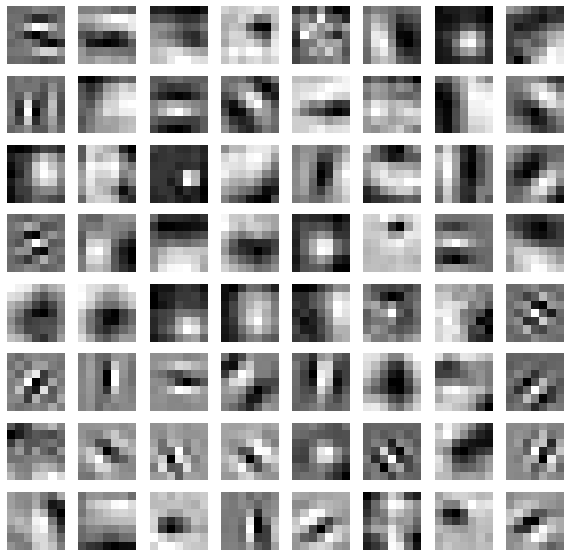

In [ ]:
# visualize the first conv layer filters
plt.figure(figsize=(10, 10))
for i, filter in enumerate(model_weights[0]):
    plt.subplot(8, 8, i+1) # (8, 8) because in conv0 we have 7x7 filters and total of 64 (see printed shapes)
    plt.imshow(filter[0, :, :].detach(), cmap='gray')
    plt.axis('off')
    plt.savefig('filter.png')
plt.show()

### Reading the Image and Defining the Transforms.

* Adding the batch dimension is an important step.

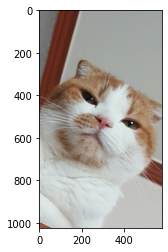

(apply the transforms): torch.Size([3, 512, 512])
(add a batch dimension): torch.Size([1, 3, 512, 512])


In [ ]:
# convert the image into PIL format, resize it and then convert it to tensor.
# read and visualize an image
img = cv.imread(f"/content/como.jpeg")
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

# define the transforms
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
])

img = np.array(img)
# apply the transforms
img = transform(img)
print('(apply the transforms):', img.size())
# unsqueeze to add a batch dimension
img = img.unsqueeze(0)
print('(add a batch dimension):', img.size())

In [ ]:
# pass the image through all the layers

# give the image as input to the first convolutional layer.
results = [conv_layers[0](img)] 
#  iterate from through the second till the last convolutional layer using a for loop
for i in range(1, len(conv_layers)):
    # give the last layer’s output as the input to the next convolutional layer
    results.append(conv_layers[i](results[-1]))
# make a copy of the `results`
outputs = results

### Visualizing the Feature Maps

We will only visualize 64 feature maps from each layer as any more than that will make the outputs really cluttered.

In [ ]:
# visualize 64 features from each layer 
# (although there are more feature maps in the upper layers)
for num_layer in range(len(outputs)):
    plt.figure(figsize=(20, 20))
    layer_viz = outputs[num_layer][0, :, :, :]
    layer_viz = layer_viz.data
    print(layer_viz.size())
    for i, filter in enumerate(layer_viz):
        if i == 64: # we will visualize only 8x8 blocks from each layer
            break #  break out of the loop if it is the 64𝑡ℎ feature map.
        plt.subplot(8, 8, i + 1)
        plt.imshow(filter, cmap='gray')
        plt.axis("off")
    # print(f"Saving layer {num_layer} feature maps...")
    plt.savefig(f"/content/output/layer_{num_layer}.png")
    # plt.show()
    plt.close()

torch.Size([64, 256, 256])
torch.Size([64, 256, 256])
torch.Size([64, 256, 256])
torch.Size([64, 256, 256])
torch.Size([64, 256, 256])
torch.Size([128, 128, 128])
torch.Size([128, 128, 128])
torch.Size([128, 128, 128])
torch.Size([128, 128, 128])
torch.Size([256, 64, 64])
torch.Size([256, 64, 64])
torch.Size([256, 64, 64])
torch.Size([256, 64, 64])
torch.Size([512, 32, 32])
torch.Size([512, 32, 32])
torch.Size([512, 32, 32])
torch.Size([512, 32, 32])


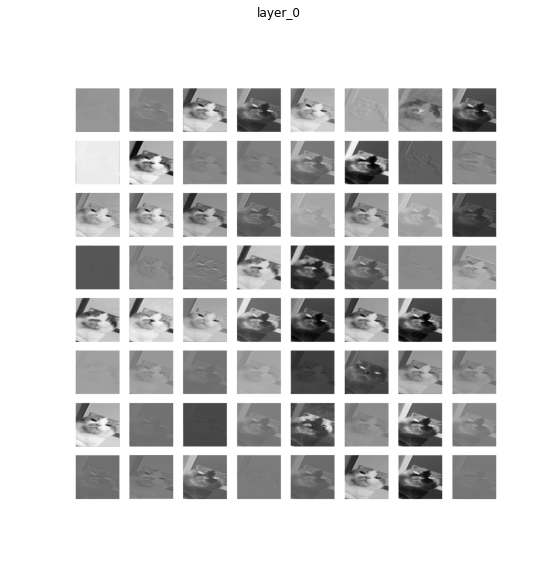

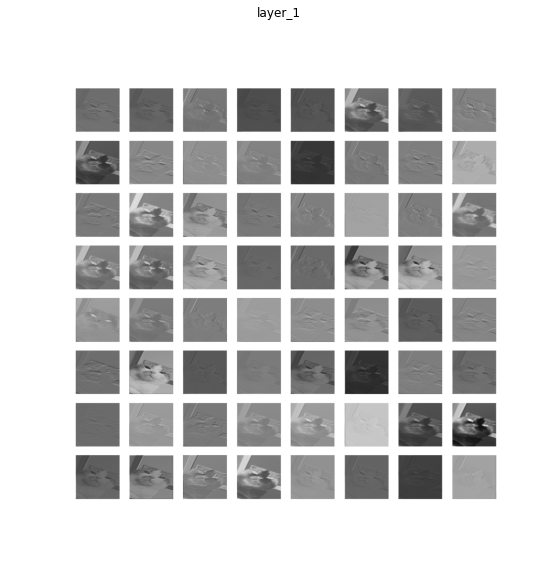

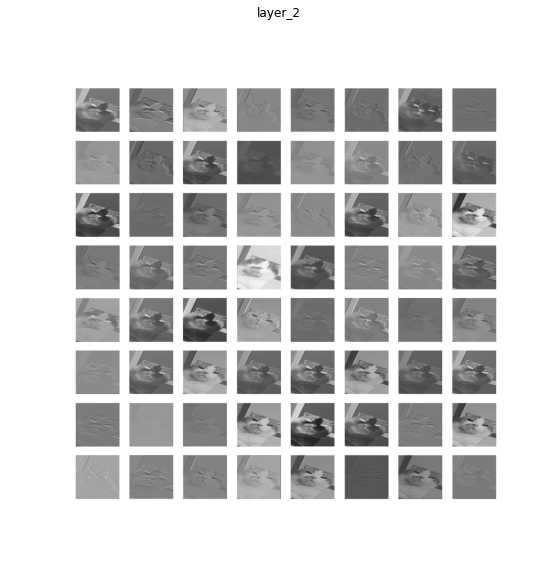

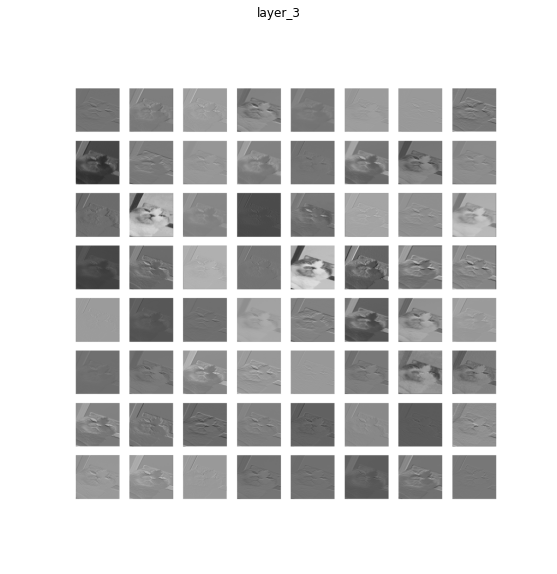

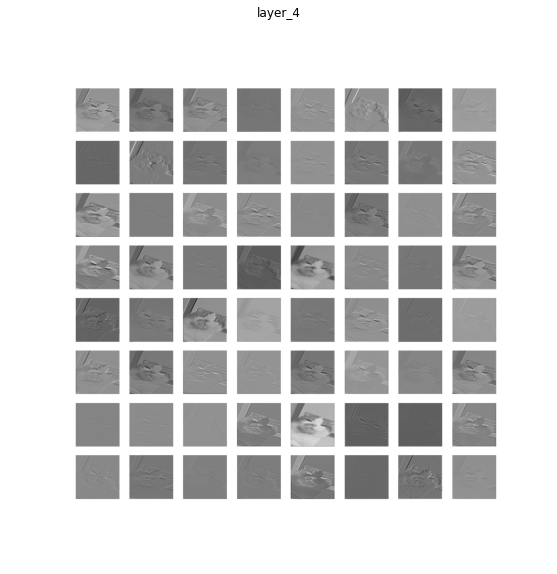

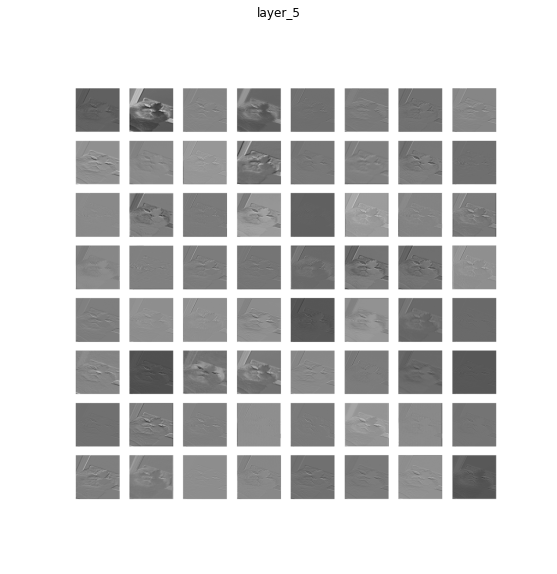

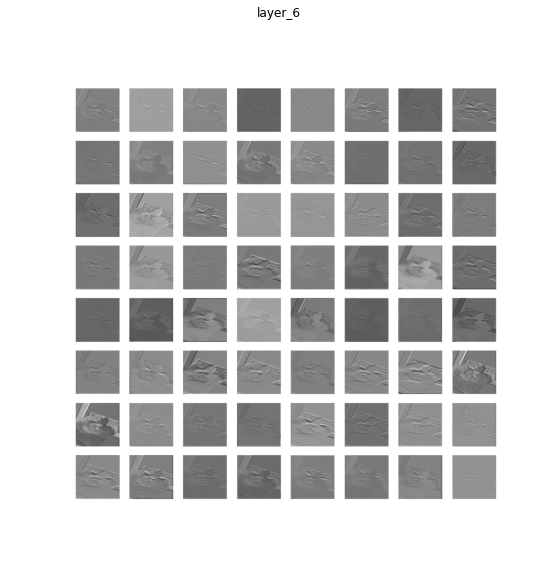

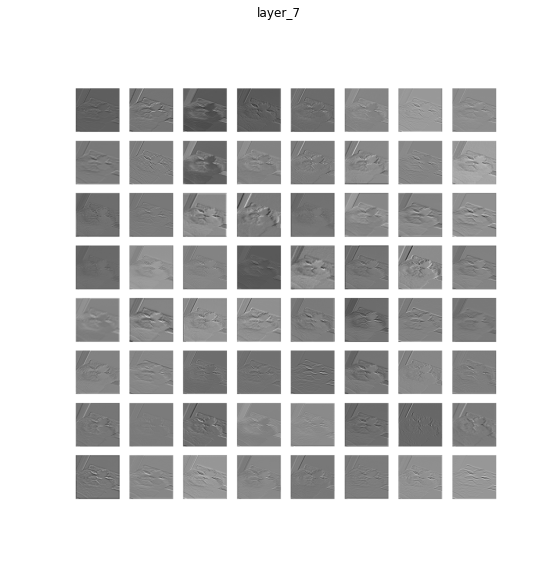

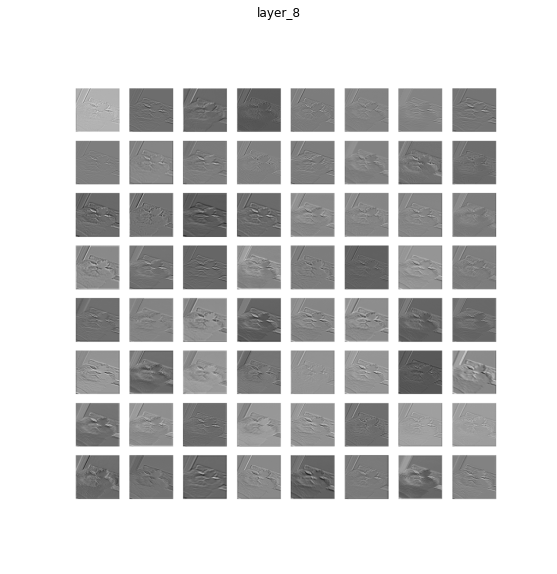

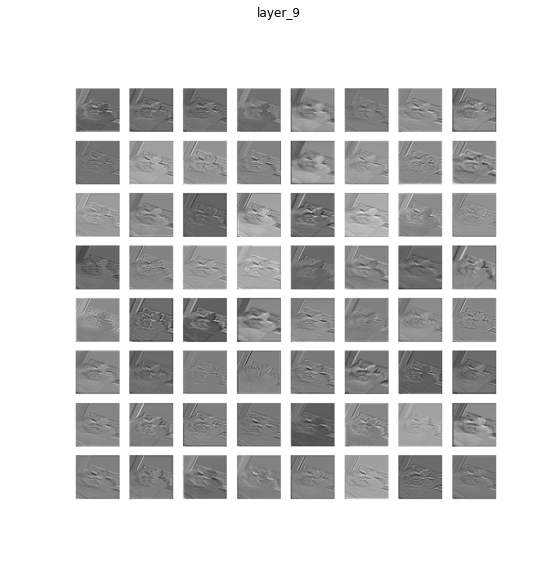

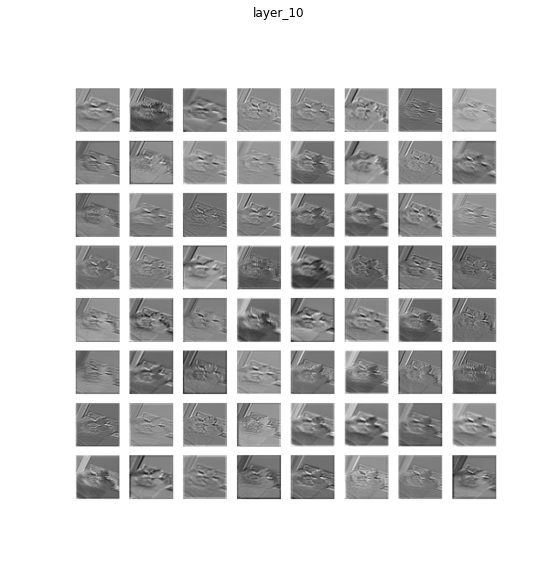

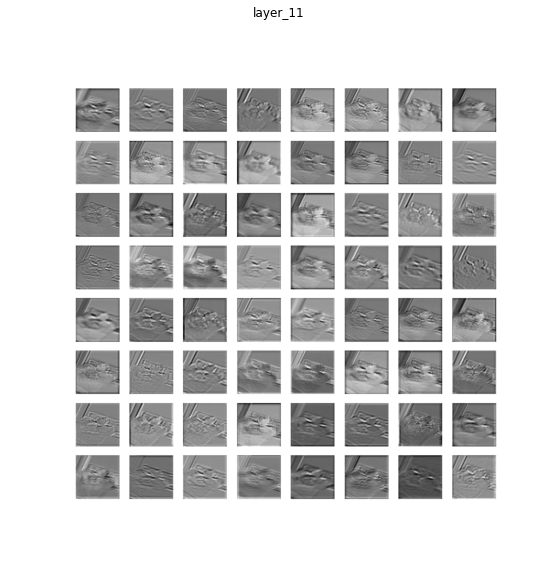

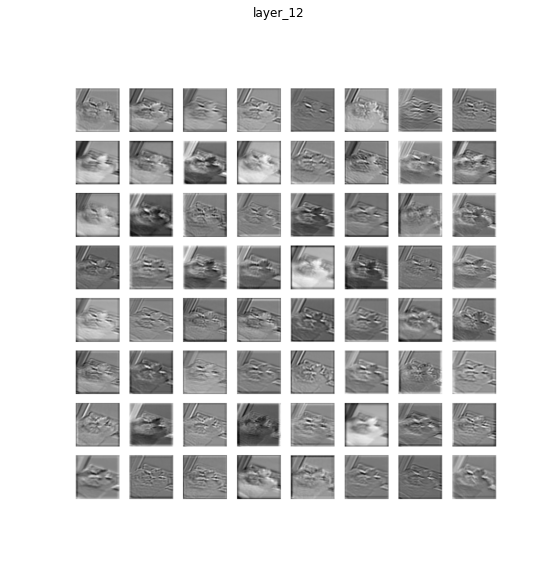

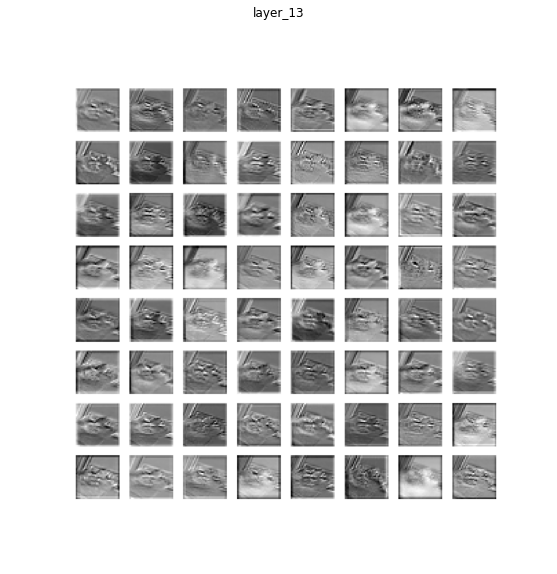

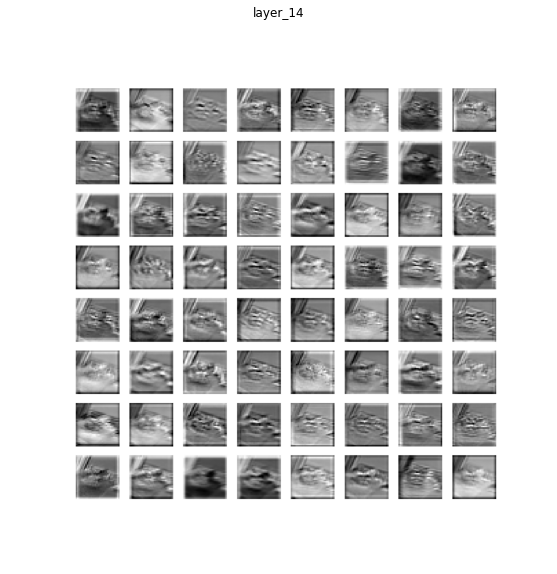

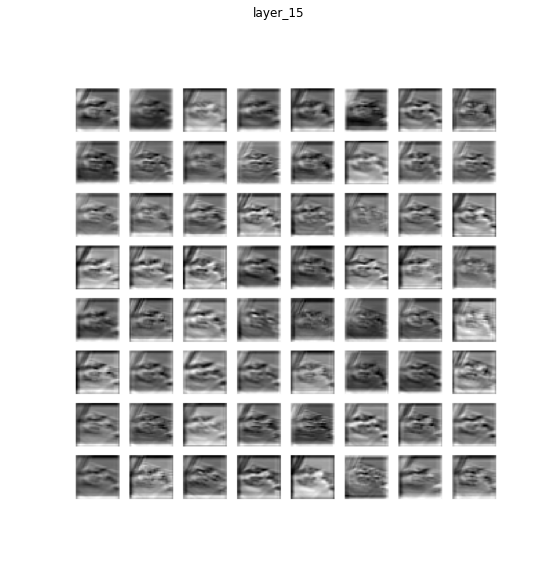

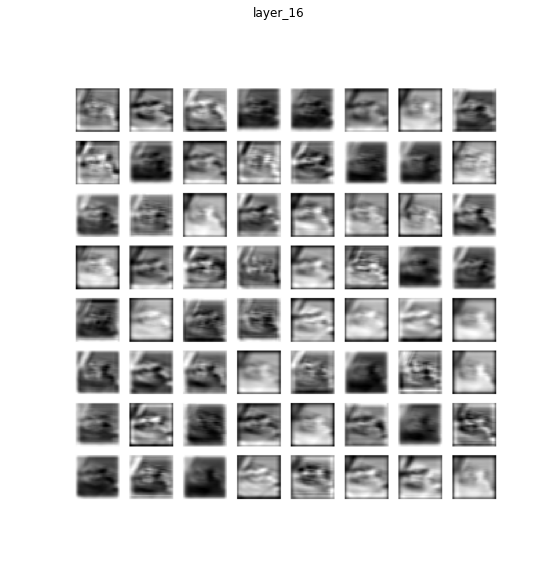

In [ ]:
for i in range(17):
    plt.figure(figsize=(10, 10))
    img = cv.imread(f"/content/output/layer_{i}.png")
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    plt.axis('off')
    plt.title(f'layer_{i}')
    plt.imshow(img)
    plt.show()